# Getting Started

## General Tips
In each homework problem, you will implement autoregressive models and run it on various datasets. Oftentime you will run it on two datasets (dataset 1 and dataset 2). In these cases, the expected outputs for dataset 1 are already provided to help as a sanity check.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted html with images.

There is a lot of freedom in this homework to write and design your own models. Hyperparameters are given as a guide to show what worked for us, but feel free to explore and use what you find is best!

Run the cells below to download and load up the starter code.

In [1]:
# magic for autoreloading of modules
%reload_ext autoreload
%autoreload 2

# get to the parent dir of mai_dul repo
import os
os.chdir('../../')
os.getcwd()

'/Users/gokul/Study/Unsupervised-DL/Git/MAI_DUL_WS24'

In [2]:
# run only once at the beginning of working on hw1
# !unzip -qq homeworks/hw1/data/hw1_data.zip -d homeworks/hw1/data/

# install latest version deepul package
!pip install -e .

Obtaining file:///Users/gokul/Study/Unsupervised-DL/Git/MAI_DUL_WS24
  Preparing metadata (setup.py) ... done
  Attempting uninstall: deepul
    Found existing installation: deepul 0.1.0
    Uninstalling deepul-0.1.0:
      Successfully uninstalled deepul-0.1.0
  DEPRECATION: Legacy editable install of deepul==0.1.0 from file:///Users/gokul/Study/Unsupervised-DL/Git/MAI_DUL_WS24 (setup.py develop) is deprecated. pip 25.0 will enforce this behaviour change. A possible replacement is to add a pyproject.toml or enable --use-pep517, and use setuptools >= 64. If the resulting installation is not behaving as expected, try using --config-settings editable_mode=compat. Please consult the setuptools documentation for more information. Discussion can be found at https://github.com/pypa/pip/issues/11457
  Running setup.py develop for deepul


In [3]:
import numpy as np
from deepul.hw1_helper import (
    # Q1
    visualize_q1_data,
    q1_sample_data_1,
    q1_sample_data_2,
    q1_save_results,
)

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

# Question 1: 1D Data

In this question, we will train simple generative models on discrete 1D data.

Execute the cell below to visualize our datasets

Dataset 1


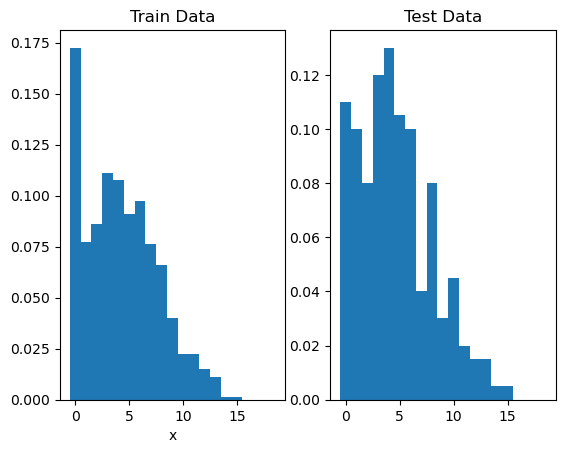

Dataset 2


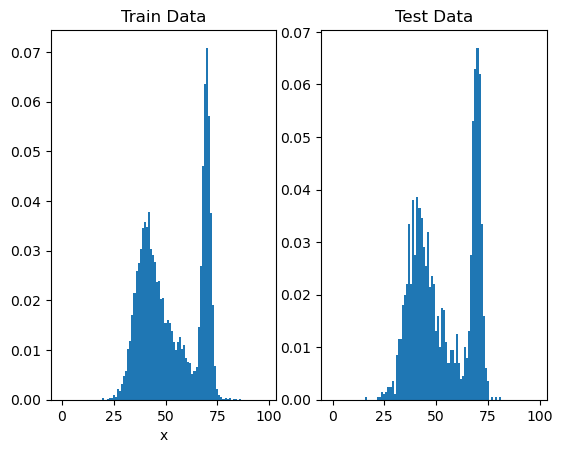

In [5]:
visualize_q1_data(dset_type=1)
visualize_q1_data(dset_type=2)

## Part (a) Fitting a Histogram

Let $\theta = (\theta_0, \dots, \theta_{d-1}) \in \mathbb{R}^{d}$ and define the model $p_\theta(x) = \frac{e^{\theta_x}}{\sum_{x'}e^{\theta_{x'}}}$

Fit $p_\theta$ with maximum likelihood via stochastic gradient descent on the training set, using $\theta$ initialized to zero. Use your favorite version of stochastic gradient descent, and optimize your hyperparameters on a validation set of your choice.

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. Plot the model probabilities in a bar graph with $\{0,\dots,d-1\}$ on the x-axis and a real number in $[0,1]$ on the y-axis.




Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [6]:
# Define the model
def model(theta):
    return nn.functional.softmax(theta, dim=0)

# Define the loss function
def loss_fn(theta, x):
    log_probs = nn.functional.log_softmax(theta, dim=0)
    return -log_probs[x].mean()

In [7]:
def q1_a(train_data, test_data, d, dset_id):
    """
    train_data: An (n_train,) numpy array of integers in {0, ..., d-1}
    test_data: An (n_test,) numpy array of integers in {0, .., d-1}
    d: The number of possible discrete values for random variable x
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
                used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (d,) of model probabilities
    """
    # Convert numpy arrays to PyTorch tensors

    train_data = torch.from_numpy(train_data)
    test_data = torch.from_numpy(test_data)

    # Hyperparameters
    if dset_id == 1:
        batch_size = 64
        lr = 0.01
        momentum = 0.9
        num_epochs = 200
    else:
        batch_size = 64
        lr = 0.01
        momentum = 0.9
        num_epochs = 200

    # Create data loaders
    train_dataset = TensorDataset(train_data)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Initialize model parameters
    theta = nn.Parameter(torch.zeros(d))

    # Initialize optimizer
    optimizer = optim.SGD([theta], lr=lr, momentum=momentum)

    # Training loop
    train_losses = []
    with torch.no_grad():
        test_losses = [loss_fn(theta, test_data).item()]

    for epoch in range(num_epochs):
        for batch in train_loader:
            x = batch[0]
            optimizer.zero_grad()
            loss = loss_fn(theta, x)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        # Evaluate on test set after each epoch
        with torch.no_grad():
            test_loss = loss_fn(theta, test_data).item()
        test_losses.append(test_loss)

    # Convert losses to numpy arrays
    train_losses = np.array(train_losses)
    test_losses = np.array(test_losses)

    # Compute final distribution
    distribution = model(theta).detach().numpy()

    return train_losses, test_losses, distribution

### Results

Once you've implemented `q1_a`, execute the cells below to visualize and save your results



Final Test Loss: 2.5487


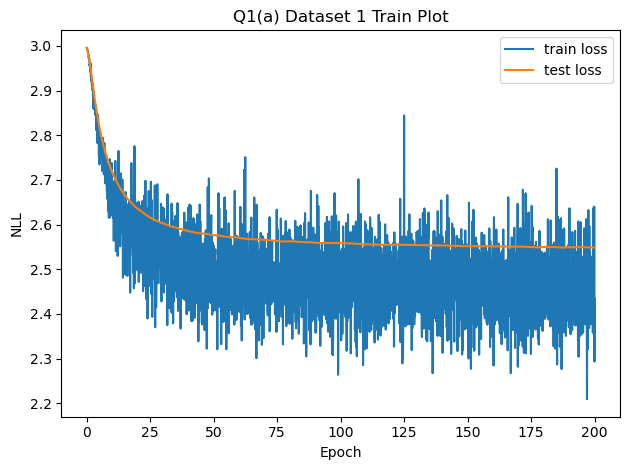

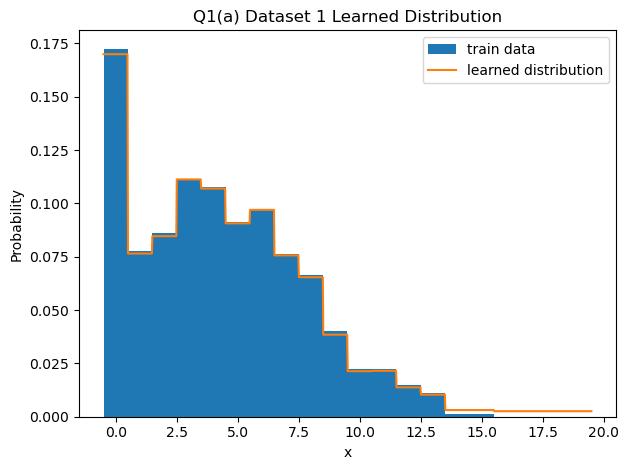

In [8]:
q1_save_results(1, 'a', q1_a)

Final Test Loss: 3.6761


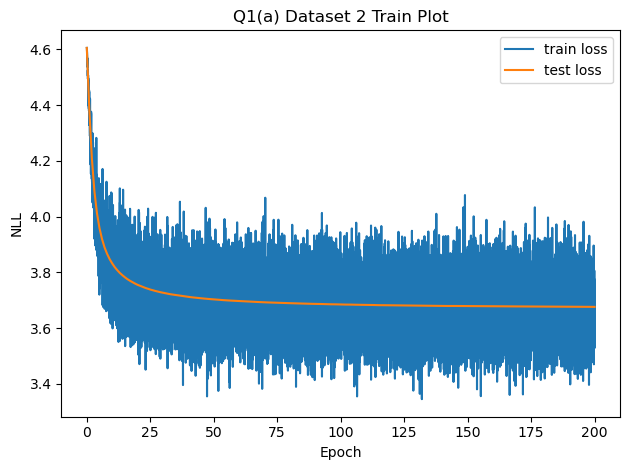

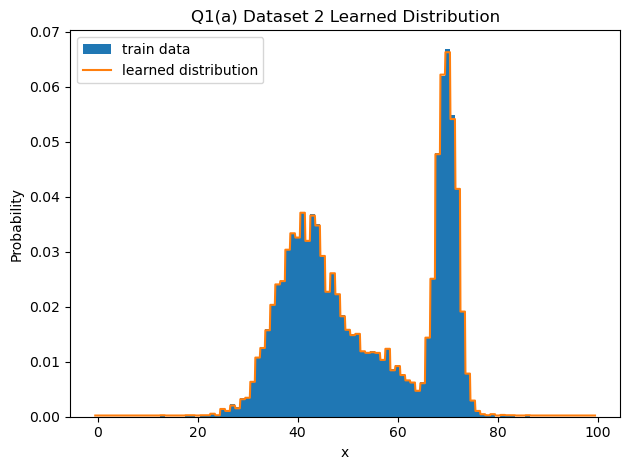

In [9]:
q1_save_results(2, 'a', q1_a)

## Part (b) Fitting Discretized Mixture of Logistics

Let us model $p_\theta(x)$ as a **discretized** mixture of 4 logistics such that $p_\theta(x) = \sum_{i=1}^4 \pi_i[\sigma((x+0.5 - \mu_i)/s_i) - \sigma((x-0.5-\mu_i)/s_i)]$

For the edge case of when $x = 0$, we replace $x-0.5$ by $-\infty$, and for $x = 99$, we replace $x+0.5$ by $\infty$.

You may find the [PixelCNN++](https://arxiv.org/abs/1701.05517) helpful for more information on discretized mixture of logistics.

**Provide the same set of corresponding deliverables as part (a)**

Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [11]:
class DiscretizedMixtureOfLogistics(nn.Module):
    def __init__(self, num_mixtures=4, d=100):
        super().__init__()
        self.num_mixtures = num_mixtures
        self.d = d
        
        # Initialize pi and s parameters
        pi_init = torch.randn(num_mixtures)
        log_s_init = torch.randn(num_mixtures)
        
        # Initialize mu uniformly across the range [0, d-1]
        mu_init = torch.linspace(0, d-1, num_mixtures)
        
        # Combine all parameters
        self.params = nn.Parameter(torch.cat([pi_init, mu_init, log_s_init]))

        # # Parameters for the mixture: pi (weights), mu (means), and s (scales)
        # self.params = nn.Parameter(torch.randn(3 * num_mixtures))
        
    def forward(self, x):
        pi, mu, log_s = torch.split(self.params, self.num_mixtures)
        pi = torch.softmax(pi, dim=0)
        s = torch.exp(log_s)  # Ensure positive scale
        
        x = x.unsqueeze(1)  # Shape: (batch_size, 1)
        mu = mu.unsqueeze(0)  # Shape: (1, num_mixtures)
        s = s.unsqueeze(0)  # Shape: (1, num_mixtures)
        
        # Compute CDF
        cdf_plus = torch.sigmoid((x + 0.5 - mu) / s)
        cdf_minus = torch.sigmoid((x - 0.5 - mu) / s)
        
        # Edge cases
        cdf_plus = torch.where(x == self.d - 1, torch.ones_like(cdf_plus), cdf_plus)
        cdf_minus = torch.where(x == 0, torch.zeros_like(cdf_minus), cdf_minus)
        
        # Compute log probabilities
        log_probs = torch.log(torch.clamp(cdf_plus - cdf_minus, min=1e-12))
        log_probs = torch.logsumexp(torch.log(pi) + log_probs, dim=1)
        
        return log_probs

In [12]:
def compute_loss(model, data):
    return -model(data).mean()

In [13]:
def q1_b(train_data, test_data, d, dset_id):
    """
    train_data: An (n_train,) numpy array of integers in {0, ..., d-1}
    test_data: An (n_test,) numpy array of integers in {0, .., d-1}
    d: The number of possible discrete values for random variable x
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
            used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (d,) of model probabilities
    """
    # Convert numpy arrays to PyTorch tensors
    train_data = torch.from_numpy(train_data).long()
    test_data = torch.from_numpy(test_data).long()

    # Hyperparameters
    batch_size = 64
    learning_rate = 0.01
    momentum = 0.9  # Added momentum for SGD
    num_epochs = 200 if dset_id == 1 else 200

    
    # Initialize model and optimizer
    model = DiscretizedMixtureOfLogistics(num_mixtures=4, d=d)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    # optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Training loop
    train_losses = []
    test_losses = [compute_loss(model, test_data).item()]
    
    for epoch in range(num_epochs):
        for i in range(0, len(train_data), batch_size):
            batch = train_data[i:i+batch_size]
            optimizer.zero_grad()
            loss = -model(batch).mean()
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        
        test_loss = compute_loss(model, test_data).item()
        test_losses.append(test_loss)
    
    # Compute final distribution
    with torch.no_grad():
        distribution = torch.exp(model(torch.arange(d))).numpy()
    
    # Normalize the distribution
    distribution /= np.sum(distribution)

    return np.array(train_losses), np.array(test_losses), distribution

### Results

Once you've implemented `q1_b`, execute the cells below to visualize and save your results



Final Test Loss: 2.5455


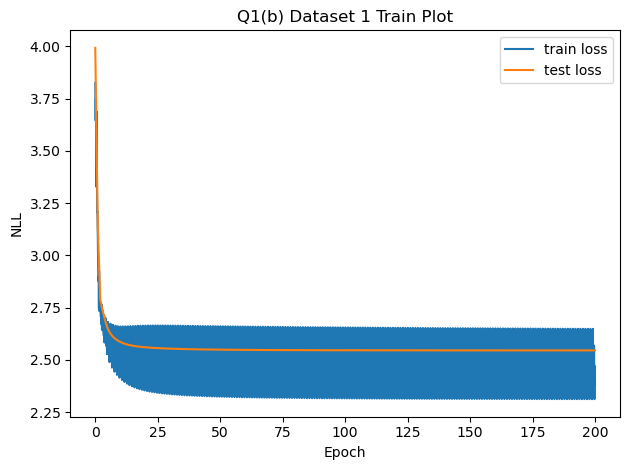

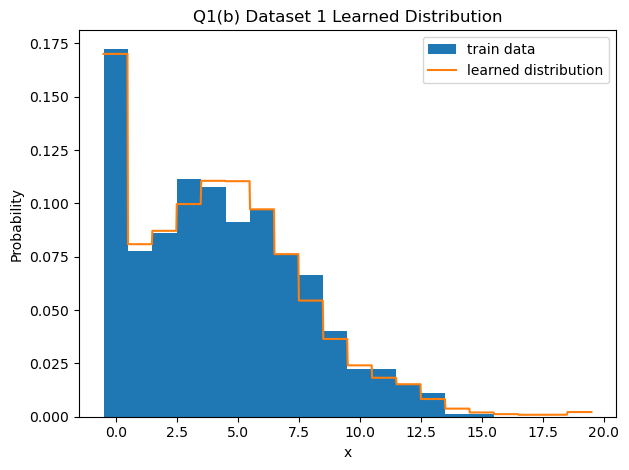

In [14]:
q1_save_results(1, 'b', q1_b)

Final Test Loss: 3.7106


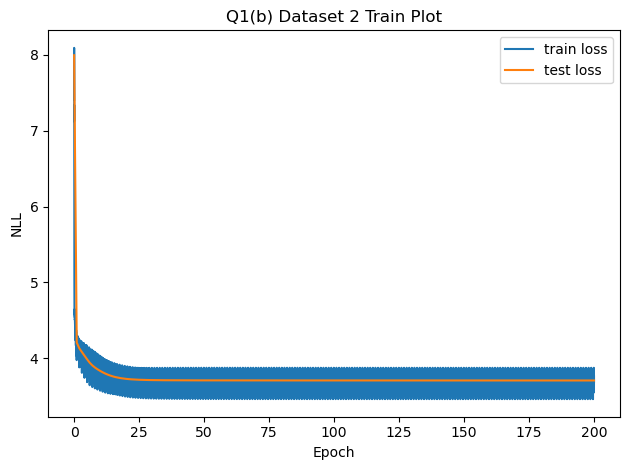

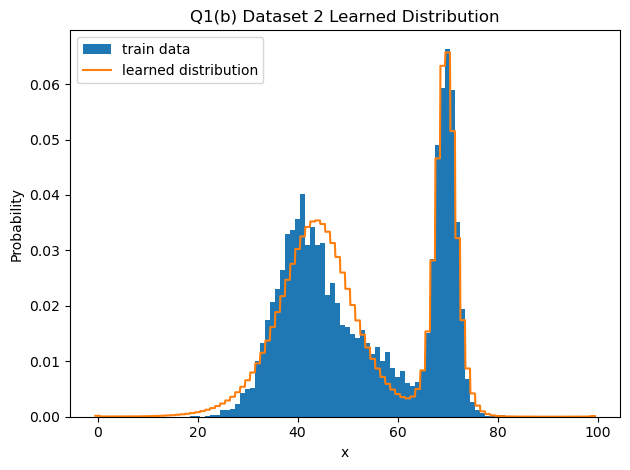

In [15]:
q1_save_results(2, 'b', q1_b)